<a href="https://colab.research.google.com/github/nimish1402/-Comparative-analysis-for-Alzheimer-s-Disease-Prediction-/blob/main/AD_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries and Dataset

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
from PIL import Image
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F



from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import Counter
from typing import Optional

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/alzheimers-dataset-4-class-of-images.zip")
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
dir_path = '/content/Alzheimer_s Dataset'
test_ds = os.path.join(dir_path, 'test')
train_ds = os.path.join(dir_path, 'train')

In [ ]:
train = ImageFolder(train_ds)
test = ImageFolder(test_ds)

class_map = {0:'Mild Demented', 1:'Moderate Demented', 2:'Non Demented', 3:'Very Mild Demented'}
class_dict = dict(Counter(train.targets))
class_dict

### 2.3 Visualise random images

In [ ]:
image_paths = []
for path in train.imgs:
    image_paths.append(path[0])
shuffled = image_paths.copy()
random.shuffle(shuffled)
plt.figure(figsize=(5,5))
for i, path in enumerate(shuffled):
    if i>3: break
    plt.subplot(2,2,i+1)
    img = Image.open(path)
    image_class = Path(path).parent.stem
    plt.title(image_class)
    plt.imshow(img)
plt.tight_layout()

# 3. Custom Dataset

In [ ]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = Image.open(self.dataset[idx][0])
        class_category = self.dataset[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, class_category

### 3.1 Shape and Channels of Image

In [ ]:
transforms.functional.get_image_size(Image.open(train.imgs[1][0]))

In [ ]:
torchvision.transforms.functional.get_image_num_channels(Image.open(train.imgs[1][0]))

In [ ]:
train_transform = v2.Compose([
                v2.Resize((128,128)),
                v2.Grayscale(num_output_channels=1),
                #v2.RandomHorizontalFlip(p=0.5), # randomly flip and rotate
                #v2.ColorJitter(0.3,0.4,0.4,0.2),
                #v2.RandomCrop(size=(128,128)),
                v2.ToTensor(),
                #v2.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

test_transform = v2.Compose([
                v2.Resize((128,128)),
                v2.Grayscale(num_output_channels=1),
                v2.ToTensor(),
                #v2.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
train_data, train_label = train.imgs, train.targets
test_data, test_label = test.imgs, test.targets

#os.path.join(dir_path,train_data)
train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)


In [ ]:
# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
torchvision.transforms.functional.get_image_num_channels(next(iter(train_dataset))[0])

# 4. Create a CNN

In [ ]:
# Create a neural net class
class Net(nn.Module):


    # Defining the Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=4096, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=num_classes)
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))

        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net(num_classes=4).to(device)

print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,10,15], gamma=0.001)

# 5. Training

In [ ]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []
all_preds = []
all_labels = []
num_epochs=30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")

Epoch 1/30, Train Loss: 1.0680, Val Loss: 1.0698, Val Accuracy: 0.48097560975609754
Epoch 2/30, Train Loss: 1.0301, Val Loss: 1.0578, Val Accuracy: 0.48097560975609754
Epoch 3/30, Train Loss: 1.0226, Val Loss: 1.0379, Val Accuracy: 0.4995121951219512
Epoch 4/30, Train Loss: 0.9863, Val Loss: 1.0157, Val Accuracy: 0.5082926829268293
Epoch 5/30, Train Loss: 0.9416, Val Loss: 0.9412, Val Accuracy: 0.5453658536585366
Epoch 6/30, Train Loss: 0.9093, Val Loss: 0.9188, Val Accuracy: 0.5590243902439025
Epoch 7/30, Train Loss: 0.8856, Val Loss: 0.9004, Val Accuracy: 0.56
Epoch 8/30, Train Loss: 0.8676, Val Loss: 0.8797, Val Accuracy: 0.5785365853658536
Epoch 9/30, Train Loss: 0.8337, Val Loss: 0.8519, Val Accuracy: 0.5912195121951219
Epoch 10/30, Train Loss: 0.8011, Val Loss: 0.8238, Val Accuracy: 0.6136585365853658
Epoch 11/30, Train Loss: 0.7661, Val Loss: 0.8028, Val Accuracy: 0.6292682926829268
Epoch 12/30, Train Loss: 0.7269, Val Loss: 0.7911, Val Accuracy: 0.6409756097560976
Epoch 13/30, 

# 6. Plots

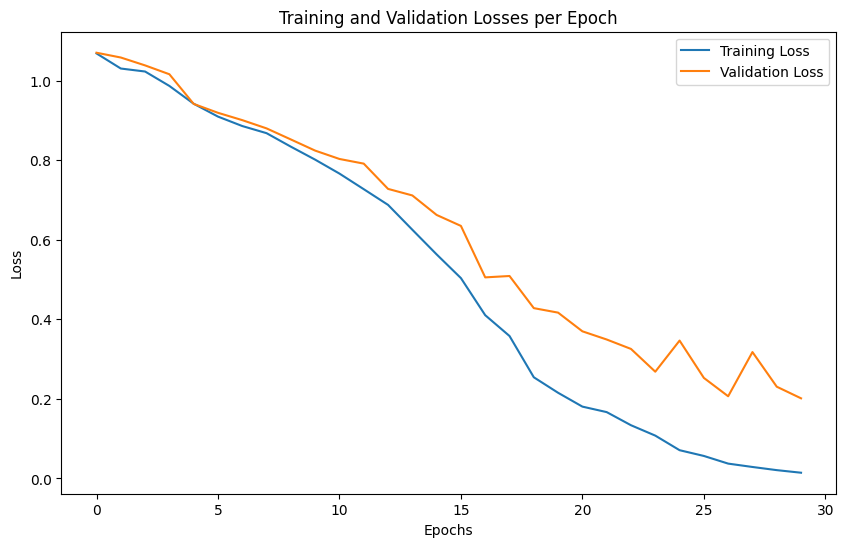

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Losses per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc=[]
for i in val_accuracies:
    acc.append(i.cpu().data.numpy())

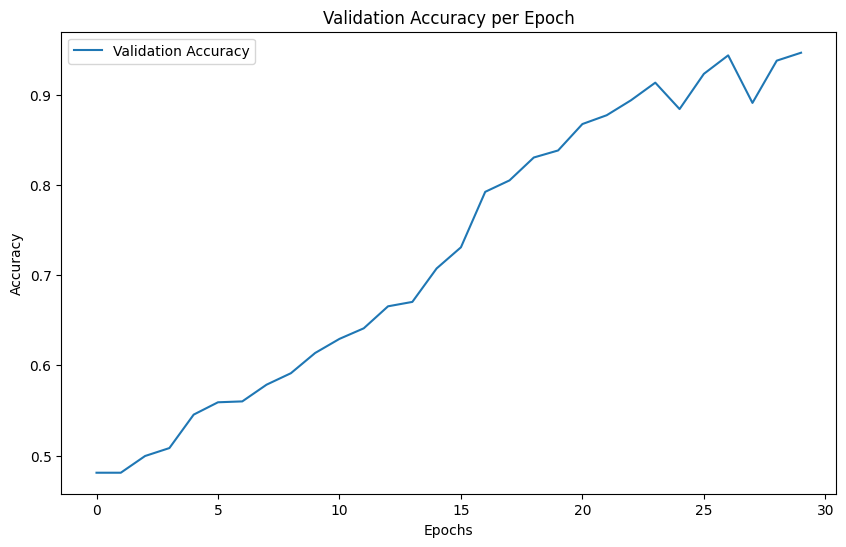

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(acc, label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def pred_class(img):
    img_tens = test_transform(img)
    img_im = img_tens.unsqueeze(0).to(device)
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)

    index = out.data.cpu().numpy().argmax()
    return index

In [ ]:
outcomes = os.listdir('/content/Alzheimer_s Dataset')
classes = {k:v for k , v in enumerate(sorted(outcomes))}
classes
#model.eval()

{0: 'test', 1: 'train'}